In [756]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [758]:
# Define data directories
img1_data_dir = '/Users/norbujamling/Desktop/mydatanew/img1_extended'
img2_data_dir = '/Users/norbujamling/Desktop/mydatanew/merged_images'

In [760]:
# Function to load images from directory
def load_images_from_dir(directory):
    images = []
    for filename in os.listdir(directory):
        if filename.endswith(".png"):
            img = tf.keras.preprocessing.image.load_img(
                os.path.join(directory, filename), 
                target_size=(28, 28), 
                color_mode='grayscale'
            )
            img = tf.keras.preprocessing.image.img_to_array(img)
            img = img.astype('float32') / 255.0  # Normalize pixel values
            images.append(img)
    return np.array(images)

In [762]:
# Load images from directories
img1_data = load_images_from_dir(img1_data_dir)
img2_data = load_images_from_dir(img2_data_dir)

In [763]:
# Get subset of data from img2_data
img1_data = img1_data
img2_data_subset = img2_data  # Change the number to get a different subset

Shape of img1_data: (19800, 28, 28, 1)
Shape of img2_data_subset: (19800, 28, 28, 1)


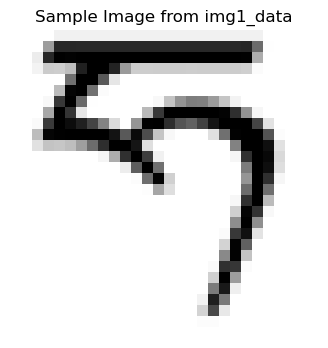

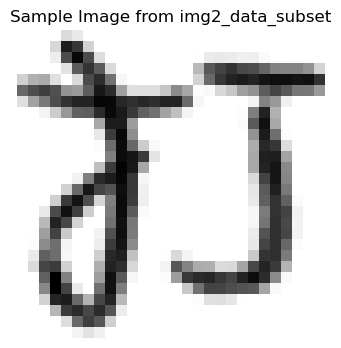

In [766]:
# Print shapes
print("Shape of img1_data:", img1_data.shape)
print("Shape of img2_data_subset:", img2_data_subset.shape)

# Display a sample image from img1_data
plt.figure(figsize=(4, 4))
plt.imshow(img1_data[0].reshape(28, 28), cmap='gray')
plt.axis('off')
plt.title('Sample Image from img1_data')
plt.show()

# Display a sample image from img2_data_subset
plt.figure(figsize=(4, 4))
plt.imshow(img2_data_subset[0].reshape(28, 28), cmap='gray')
plt.axis('off')
plt.title('Sample Image from img2_data_subset')
plt.show()

In [768]:
input_shape=(28,28,1)

In [770]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Input(shape=input_shape))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))  
    model.add(layers.Dense(28*28*1, activation='sigmoid'))
    model.add(layers.Reshape((28, 28, 1)))
    return model


In [772]:
generator = make_generator_model()
generator.summary()

Model: "sequential_307"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_152 (Flatten)           │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_181 (Dense)               │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_182 (Dense)               │ (None, 784)            │       101,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_12 (Reshape)            │ (None, 28, 28, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 201,616 (787.56 KB)

 Trainable params: 201,616 (787.56 KB)

 Non-trainable params: 0 (0.00 B)

In [774]:
# Define discriminator model
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Input(shape=input_shape))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))  
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

In [776]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_308"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_153 (Flatten)           │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_183 (Dense)               │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_184 (Dense)               │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,609 (393.00 KB)

 Trainable params: 100,609 (393.00 KB)

 Non-trainable params: 0 (0.00 B)

In [778]:
class CycleGAN(tf.keras.Model):
    def __init__(self, generator_g, generator_f, discriminator_x, discriminator_y):
        super(CycleGAN, self).__init__()
        self.generator_g = generator_g
        self.generator_f = generator_f
        self.discriminator_x = discriminator_x
        self.discriminator_y = discriminator_y

    def compile(self, gen_g_optimizer, gen_f_optimizer, disc_x_optimizer, disc_y_optimizer, cycle_loss_fn):
        super(CycleGAN, self).compile()
        self.gen_g_optimizer = gen_g_optimizer
        self.gen_f_optimizer = gen_f_optimizer
        self.disc_x_optimizer = disc_x_optimizer
        self.disc_y_optimizer = disc_y_optimizer
        self.cycle_loss_fn = cycle_loss_fn

    def train_step(self, batch_data):
        real_x, real_y = batch_data

        with tf.GradientTape(persistent=True) as tape:
            # Generate fake images
            fake_y = self.generator_g(real_x, training=True)
            fake_x = self.generator_f(real_y, training=True)

            # Generate reconstructed images
            reconstructed_x = self.generator_f(fake_y, training=True)
            reconstructed_y = self.generator_g(fake_x, training=True)

            # Compute cycle consistency loss
            cycle_loss_x = self.cycle_loss_fn(real_x, reconstructed_x)
            cycle_loss_y = self.cycle_loss_fn(real_y, reconstructed_y)
            total_cycle_loss = cycle_loss_x + cycle_loss_y

            # Compute generator adversarial loss
            gen_g_adv_loss = -tf.reduce_mean(self.discriminator_y(fake_y))
            gen_f_adv_loss = -tf.reduce_mean(self.discriminator_x(fake_x))
            total_gen_adv_loss = gen_g_adv_loss + gen_f_adv_loss

            # Total generator loss
            total_gen_loss = total_gen_adv_loss + total_cycle_loss

            # Compute discriminator adversarial loss
            disc_x_loss_real = tf.reduce_mean(tf.square(self.discriminator_x(real_x) - 1))
            disc_x_loss_fake = tf.reduce_mean(tf.square(self.discriminator_x(fake_x)))
            disc_x_loss = 0.5 * (disc_x_loss_real + disc_x_loss_fake)

            disc_y_loss_real = tf.reduce_mean(tf.square(self.discriminator_y(real_y) - 1))
            disc_y_loss_fake = tf.reduce_mean(tf.square(self.discriminator_y(fake_y)))
            disc_y_loss = 0.5 * (disc_y_loss_real + disc_y_loss_fake)

        # Compute gradients and update weights
        gen_g_gradients = tape.gradient(total_gen_loss, self.generator_g.trainable_variables)
        gen_f_gradients = tape.gradient(total_gen_loss, self.generator_f.trainable_variables)
        disc_x_gradients = tape.gradient(disc_x_loss, self.discriminator_x.trainable_variables)
        disc_y_gradients = tape.gradient(disc_y_loss, self.discriminator_y.trainable_variables)

        self.gen_g_optimizer.apply_gradients(zip(gen_g_gradients, self.generator_g.trainable_variables))
        self.gen_f_optimizer.apply_gradients(zip(gen_f_gradients, self.generator_f.trainable_variables))
        self.disc_x_optimizer.apply_gradients(zip(disc_x_gradients, self.discriminator_x.trainable_variables))
        self.disc_y_optimizer.apply_gradients(zip(disc_y_gradients, self.discriminator_y.trainable_variables))

        return {
            "total_gen_loss": total_gen_loss,
            "total_cycle_loss": total_cycle_loss,
            "total_gen_adv_loss": total_gen_adv_loss,
            "disc_x_loss": disc_x_loss,
            "disc_y_loss": disc_y_loss
        }


In [780]:
# Instantiate generator and discriminator models
generator_g = make_generator_model()
generator_f = make_generator_model()
discriminator_x = make_discriminator_model()
discriminator_y = make_discriminator_model()

# Compile CycleGAN model
cycle_gan_model = CycleGAN(generator_g, generator_f, discriminator_x, discriminator_y)
cycle_gan_model.compile(
    gen_g_optimizer=tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    gen_f_optimizer=tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    disc_x_optimizer=tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    disc_y_optimizer=tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    cycle_loss_fn=tf.keras.losses.Huber()
)


In [806]:
# Train the model
cycle_gan_model.fit(
    img1_data, img2_data_subset,
    epochs=100,
    batch_size=32
)

Epoch 1/100
619/619 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - disc_x_loss: 0.5000 - disc_y_loss: 0.5000 - total_cycle_loss: 0.0159 - total_gen_adv_loss: -6.7134e-06 - total_gen_loss: 0.0159
Epoch 2/100
619/619 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - disc_x_loss: 0.5000 - disc_y_loss: 0.5000 - total_cycle_loss: 0.0158 - total_gen_adv_loss: -6.6542e-06 - total_gen_loss: 0.0158
Epoch 3/100
619/619 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - disc_x_loss: 0.5000 - disc_y_loss: 0.5000 - total_cycle_loss: 0.0157 - total_gen_adv_loss: -6.6093e-06 - total_gen_loss: 0.0157
Epoch 4/100
619/619 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - disc_x_loss: 0.5000 - disc_y_loss: 0.5000 - total_cycle_loss: 0.0156 - total_gen_adv_loss: -6.5498e-06 - total_gen_loss: 0.0156
Epoch 5/100
619/619 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - disc_x_loss: 0.5000 - disc_y_loss: 0.5000 - total_cycle_loss: 0.0155 - total_gen_adv_loss: -6.4852e-06 - total_gen_loss: 0.0155
Epoch 6/100
619/619 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - disc_x_loss: 0.5000 - disc_y_l

Shape of img1_data: (19800, 28, 28, 1)
Shape of img2_data_subset: (19800, 28, 28, 1)


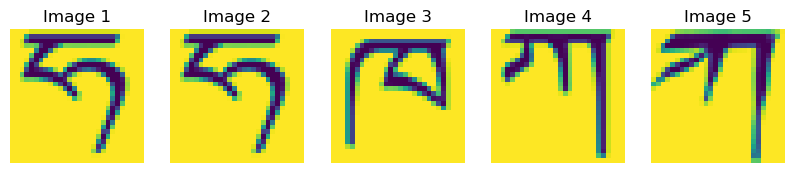

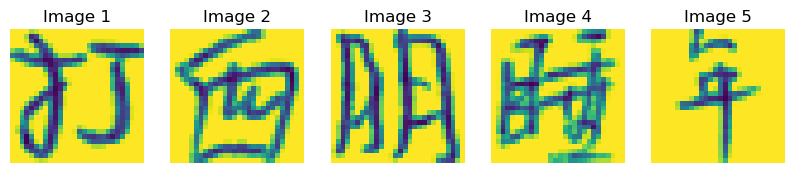

In [808]:
import matplotlib.pyplot as plt

# Check shapes
print("Shape of img1_data:", img1_data.shape)
print("Shape of img2_data_subset:", img2_data_subset.shape)

# Visualize images from img1_data
plt.figure(figsize=(10, 5))
for i in range(5):  # Plot the first 5 images
    plt.subplot(1, 5, i + 1)
    plt.imshow(img1_data[i])  # Assuming img1_data contains images in the correct format
    plt.axis('off')
    plt.title('Image {}'.format(i + 1))
plt.show()

# Visualize images from img2_data_subset
plt.figure(figsize=(10, 5))
for i in range(5):  # Plot the first 5 images
    plt.subplot(1, 5, i + 1)
    plt.imshow(img2_data_subset[i])  # Assuming img2_data_subset contains images in the correct format
    plt.axis('off')
    plt.title('Image {}'.format(i + 1))
plt.show()


In [810]:
# Generate images using the trained generator
generated_images = generator_g.predict(img1_data)

619/619 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step


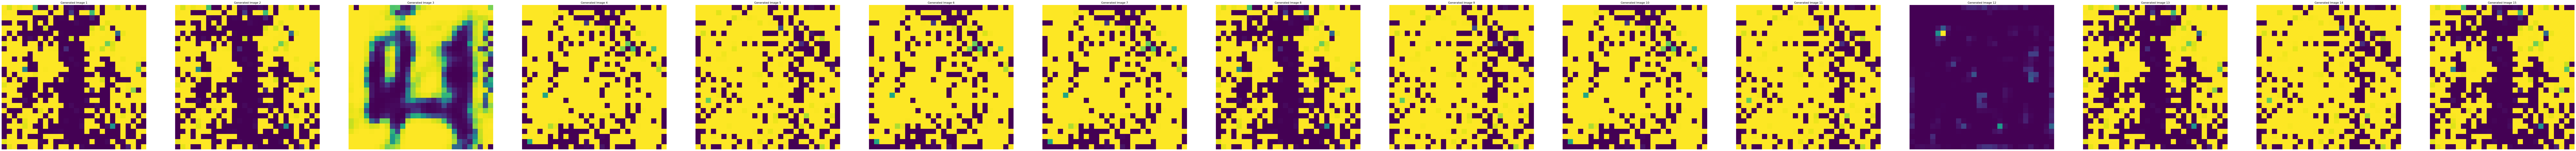

In [814]:
# Visualize the generated images
import matplotlib.pyplot as plt
plt.figure(figsize=(200,100))
for i in range(15):  # Visualize the first 5 generated images
    plt.subplot(1, 15, i + 1)
    plt.imshow(generated_images[i])  # Assuming generated_images is in the correct format
    plt.axis('off')
    plt.title('Generated Image {}'.format(i + 1))
plt.show()

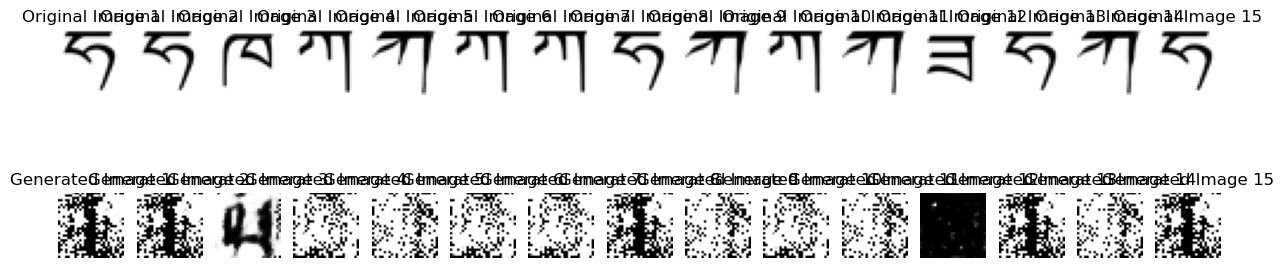

In [818]:
# Assuming original_images contains the original images and generated_images contains the generated images
original_images = img1_data
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))  # Adjust the figure size as needed
for i in range(15):  # Visualize the first 15 original and generated image pairs
    plt.subplot(3, 15, i + 1)
    plt.imshow(original_images[i].reshape(28, 28), cmap='gray')  # Assuming the images are grayscale
    plt.axis('off')
    plt.title('Original Image {}'.format(i + 1))

    plt.subplot(3, 15, i + 16)
    plt.imshow(generated_images[i].reshape(28, 28), cmap='gray')  # Assuming the images are grayscale
    plt.axis('off')
    plt.title('Generated Image {}'.format(i + 1))

plt.show()
